<a href="https://colab.research.google.com/github/Kryptera-K/HII-Laguerre-Momentum-Volume-Fusion-Strategy-LMVF-/blob/main/HII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "HII"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("HII_clean.csv", index=False)
df

/tmp/ipython-input-1148621437.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2011-03-22,30.095911,30.184213,27.294237,28.675005,491400
2011-03-23,29.903244,30.344768,29.662413,29.758745,601200
2011-03-24,29.903244,30.103937,29.822968,30.103937,230400
2011-03-25,31.508783,31.508783,29.903240,30.103933,497400
2011-03-28,30.304636,31.308101,30.304636,31.308101,53100
...,...,...,...,...,...
2025-11-17,309.739990,314.660004,308.339996,314.000000,321000
2025-11-18,309.160004,312.369995,305.369995,310.320007,308900
2025-11-19,309.739990,311.049988,304.799988,307.000000,312900


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9
LRSI_GAMMA = 0.5
LRSI_LEVEL = 0.5
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5
VOLUME_SHIFT = 10

# -------------------------
# Indicator Functions
# -------------------------

def laguerre_rsi_cross_above_level(df, level=LRSI_LEVEL, gamma=LRSI_GAMMA):
    df = df.copy()
    df['LRsi'] = calculate_laguerre_rsi(df['Close'], gamma)
    return (df['LRsi'] > level) & (df['LRsi'].shift(1) <= level)


def calculate_laguerre_rsi(series, gamma=LRSI_GAMMA):
    """
    Calculate Laguerre RSI for a pandas Series of close prices.
    Returns a pandas Series of Laguerre RSI values.
    """
    L0 = L1 = L2 = L3 = 0
    lrsi = []

    for price in series:
        L0 = (1 - gamma) * price + gamma * L0
        L1 = -gamma * L0 + L0 + gamma * L1
        L2 = -gamma * L1 + L1 + gamma * L2
        L3 = -gamma * L2 + L2 + gamma * L3

        CU = max(L0 - L1, 0) + max(L1 - L2, 0) + max(L2 - L3, 0)
        CD = max(L1 - L0, 0) + max(L2 - L1, 0) + max(L3 - L2, 0)

        lrsi.append(CU / (CU + CD) if (CU + CD) != 0 else 0)

    return pd.Series(lrsi, index=series.index)


def volume_is_rising(df, shift=VOLUME_SHIFT):
    return df['Volume'] > df['Volume'].shift(shift)


def price_cross_kijun_bearish(df):
    df = calculate_ichimoku(df)
    return (df['Close'].shift(1) > df['kijun_sen'].shift(1)) & (df['Close'] < df['kijun_sen'])


def calculate_ichimoku(df, tenkan_period=ICHIMOKU_TENKAN_PERIOD, kijun_period=ICHIMOKU_KIJUN_PERIOD, senkou_b_period=ICHIMOKU_SENKOU_B_PERIOD, displacement=ICHIMOKU_DISPLACEMENT):
    df = df.copy()

    # Lines
    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() + df['Low'].rolling(tenkan_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() + df['Low'].rolling(kijun_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() + df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)

    return df


def qqe_value2_rising(df, shift=QQE_SHIFT):
    df = calculate_qqe(df)
    return df['QQE_Value2'] > df['QQE_Value2'].shift(shift)


def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    """
    Calculate QQE lines (Value1 & Value2) based on RSI smoothing and ATR-like smoothing.
    """
    df = df.copy()

    # --- RSI ---
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # --- Smoothed RSI ---
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # --- RSI Delta & ATR-like smoothing ---
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # --- QQE Calculation ---
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df



# -------------------------
# Entry conditions
# -------------------------

df["LRsi_Cross_Above_Level"] = laguerre_rsi_cross_above_level(df)
df["Volume_Rising"] = volume_is_rising(df)

# -------------------------
# Exit conditions
# -------------------------

df["Ichimoku_Price_Cross_Kijun_Bearish"] = price_cross_kijun_bearish(df)
df["QQE_Value2_Rising"] = qqe_value2_rising(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'LRsi_Cross_Above_Level',
    'Volume_Rising',
]
exit_conditions = [
    'Ichimoku_Price_Cross_Kijun_Bearish',
    'QQE_Value2_Rising',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

/tmp/ipython-input-2104304326.py:92: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')


Start                                2011-03-22 00:00:00
End                                  2025-11-21 00:00:00
Period                                3692 days 00:00:00
Start Value                                     100000.0
End Value                                 1919543.369506
Total Return [%]                              1819.54337
Benchmark Return [%]                          950.601427
Max Gross Exposure [%]                             100.0
Total Fees Paid                             86902.306643
Max Drawdown [%]                               29.914977
Max Drawdown Duration                  487 days 00:00:00
Total Trades                                          54
Total Closed Trades                                   53
Total Open Trades                                      1
Open Trade PnL                             121287.548177
Win Rate [%]                                   43.396226
Best Trade [%]                                 66.390399
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2011-03-22 00:00:00
End                           2025-11-21 00:00:00
Period                         3692 days 00:00:00
Start Value                              100000.0
End Value                          1050601.427011
Total Return [%]                       950.601427
Benchmark Return [%]                   950.601427
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        49.876838
Max Drawdown Duration           982 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      950601.427011
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-3272902531.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3272902531.py:79: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



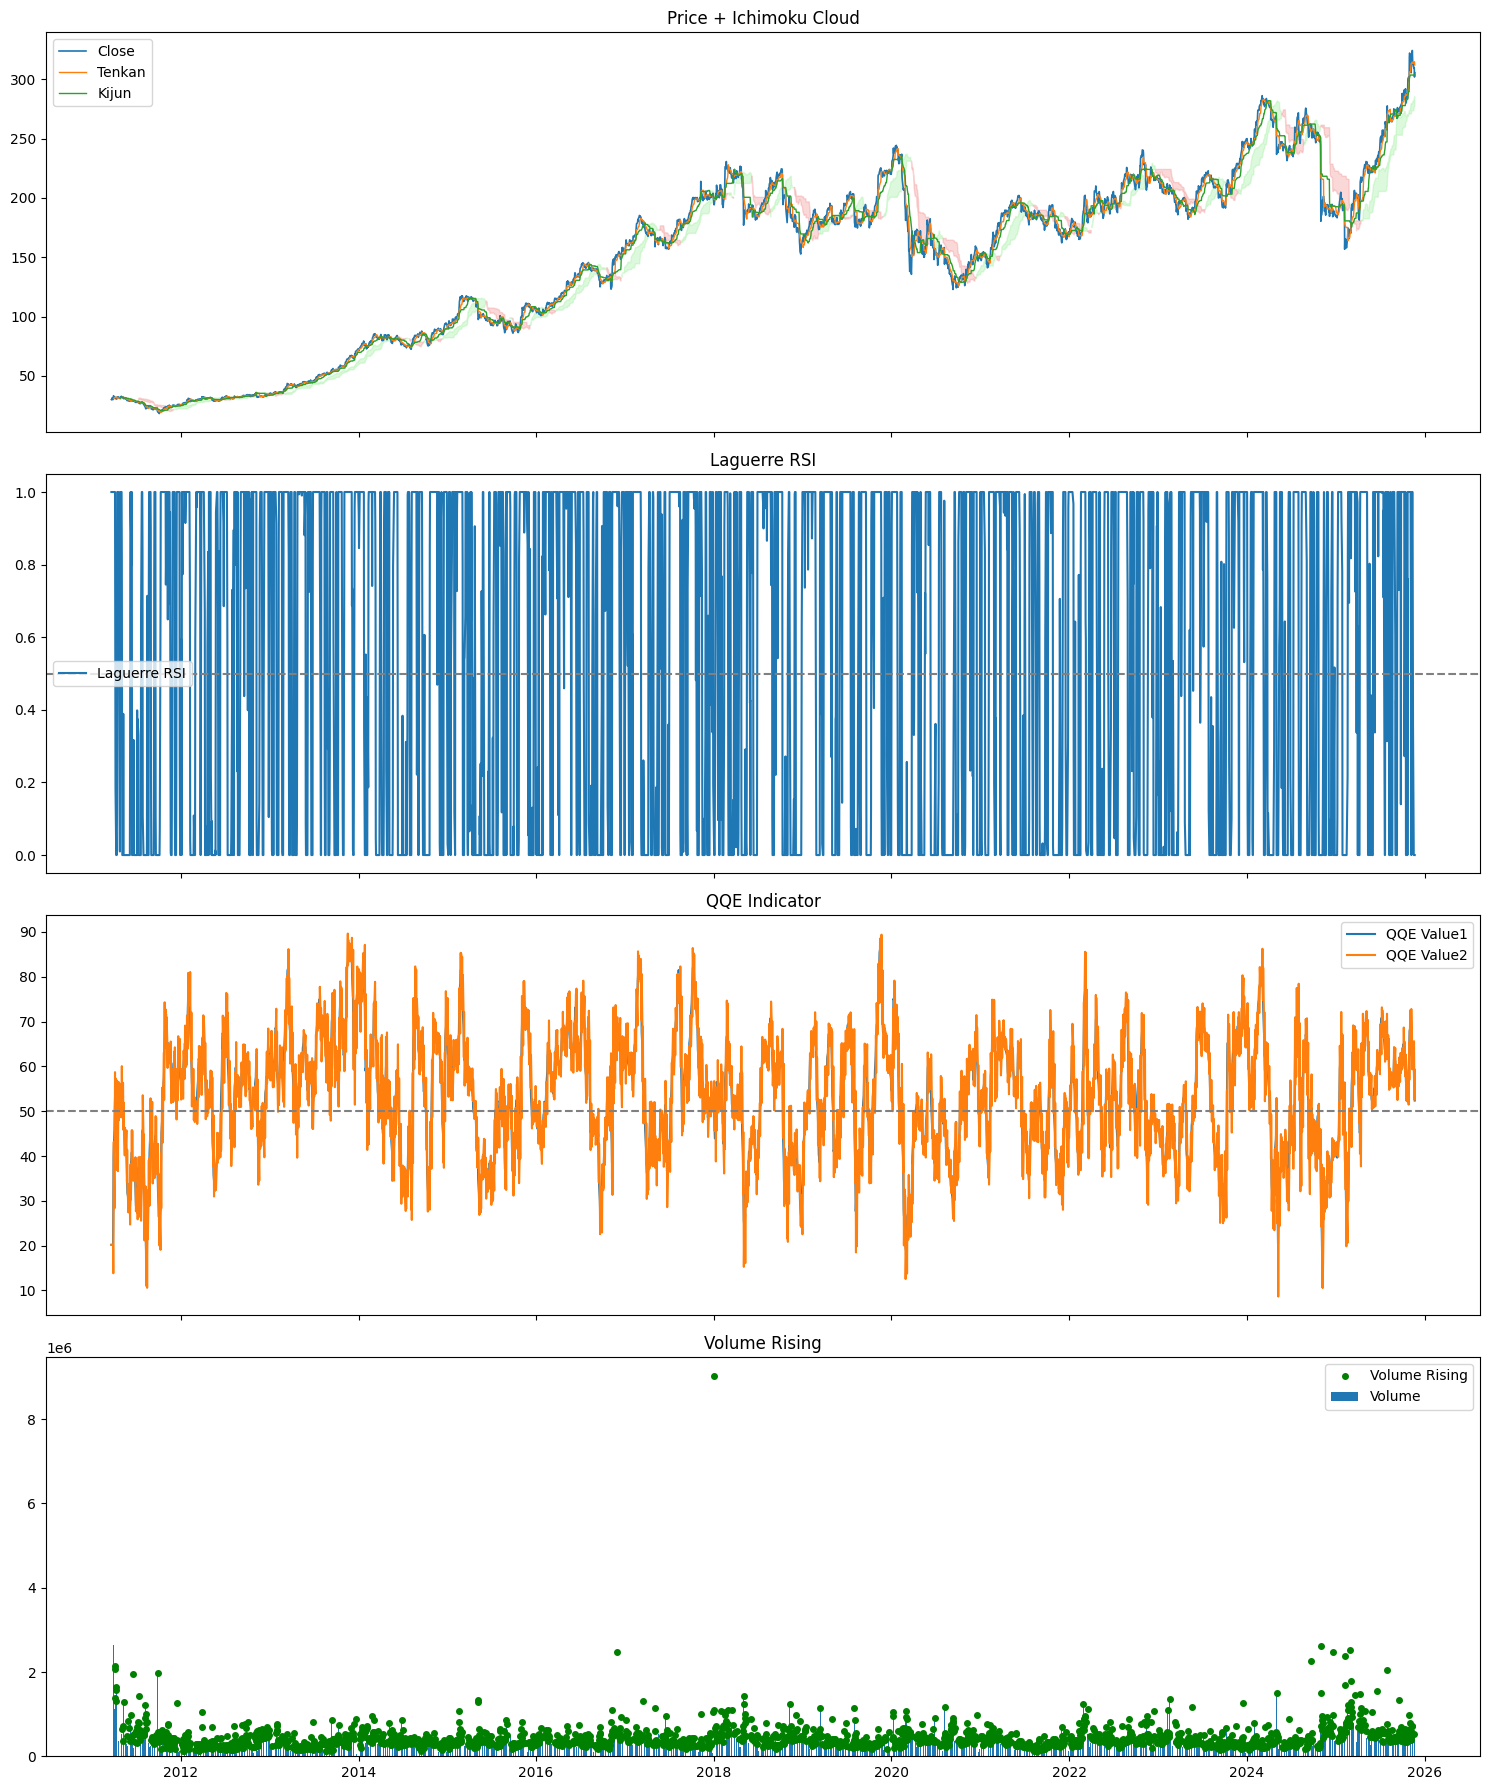

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# ============================================================
# Download Data
# ============================================================

symbol = "HII"
start_date = "2000-01-01"
end_date = "2026-01-01"

df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)
df.dropna(inplace=True)

# ============================================================
# Indicator Parameters
# ============================================================

ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9
LRSI_GAMMA = 0.5
LRSI_LEVEL = 0.5
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5
VOLUME_SHIFT = 10

# ============================================================
# Indicator Functions
# ============================================================

def calculate_laguerre_rsi(series, gamma=LRSI_GAMMA):
    L0 = L1 = L2 = L3 = 0
    lrsi = []

    for price in series:
        L0 = (1 - gamma) * price + gamma * L0
        L1 = -gamma * L0 + L0 + gamma * L1
        L2 = -gamma * L1 + L1 + gamma * L2
        L3 = -gamma * L2 + L2 + gamma * L3

        CU = max(L0 - L1, 0) + max(L1 - L2, 0) + max(L2 - L3, 0)
        CD = max(L1 - L0, 0) + max(L2 - L1, 0) + max(L3 - L2, 0)

        lrsi.append(CU / (CU + CD) if (CU + CD) != 0 else 0)

    return pd.Series(lrsi, index=series.index)


def calculate_ichimoku(df):
    df = df.copy()
    df["tenkan_sen"] = (df["High"].rolling(ICHIMOKU_TENKAN_PERIOD).max() +
                        df["Low"].rolling(ICHIMOKU_TENKAN_PERIOD).min()) / 2
    df["kijun_sen"] = (df["High"].rolling(ICHIMOKU_KIJUN_PERIOD).max() +
                       df["Low"].rolling(ICHIMOKU_KIJUN_PERIOD).min()) / 2
    df["senkou_span_a"] = ((df["tenkan_sen"] + df["kijun_sen"]) / 2).shift(ICHIMOKU_DISPLACEMENT)
    df["senkou_span_b"] = ((df["High"].rolling(ICHIMOKU_SENKOU_B_PERIOD).max() +
                            df["Low"].rolling(ICHIMOKU_SENKOU_B_PERIOD).min()) / 2).shift(ICHIMOKU_DISPLACEMENT)
    df["chikou_span"] = df["Close"].shift(-ICHIMOKU_DISPLACEMENT)
    return df


def calculate_qqe(df):
    df = df.copy()

    delta = df["Close"].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/QQE_PERIOD, adjust=False).mean()
    roll_down = down.ewm(alpha=1/QQE_PERIOD, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    rsi_ma = rsi.rolling(QQE_SMOOTH).mean().fillna(method="bfill")

    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/QQE_SMOOTH, adjust=False).mean()

    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i - 1]
        prev_value1 = value1.iloc[i - 1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * QQE_FACTOR * atr

    df["QQE_Value1"] = value1
    df["QQE_Value2"] = value2
    return df


# ============================================================
# Apply Indicators
# ============================================================

df = calculate_ichimoku(df)
df["LRsi"] = calculate_laguerre_rsi(df["Close"])
df = calculate_qqe(df)
df["Volume_Rising"] = df["Volume"] > df["Volume"].shift(VOLUME_SHIFT)

# ============================================================
# Plotting
# ============================================================

fig, axs = plt.subplots(4, 1, figsize=(15, 18), sharex=True)

# ------------------------------------------------------------
# 1. Price + Ichimoku Cloud
# ------------------------------------------------------------

axs[0].plot(df.index, df["Close"], label="Close", linewidth=1.2)
axs[0].plot(df.index, df["tenkan_sen"], label="Tenkan", linewidth=1)
axs[0].plot(df.index, df["kijun_sen"], label="Kijun", linewidth=1)
axs[0].fill_between(df.index, df["senkou_span_a"], df["senkou_span_b"],
                    where=df["senkou_span_a"] >= df["senkou_span_b"],
                    color="lightgreen", alpha=0.3)
axs[0].fill_between(df.index, df["senkou_span_a"], df["senkou_span_b"],
                    where=df["senkou_span_a"] < df["senkou_span_b"],
                    color="lightcoral", alpha=0.3)
axs[0].set_title("Price + Ichimoku Cloud")
axs[0].legend()

# ------------------------------------------------------------
# 2. Laguerre RSI
# ------------------------------------------------------------

axs[1].plot(df.index, df["LRsi"], label="Laguerre RSI")
axs[1].axhline(LRSI_LEVEL, color="gray", linestyle="--")
axs[1].set_title("Laguerre RSI")
axs[1].legend()

# ------------------------------------------------------------
# 3. QQE Value1 & Value2
# ------------------------------------------------------------

axs[2].plot(df.index, df["QQE_Value1"], label="QQE Value1")
axs[2].plot(df.index, df["QQE_Value2"], label="QQE Value2")
axs[2].axhline(QQE_LEVEL, color="gray", linestyle="--")
axs[2].set_title("QQE Indicator")
axs[2].legend()

# ------------------------------------------------------------
# 4. Volume Rising
# ------------------------------------------------------------

axs[3].bar(df.index, df["Volume"], label="Volume")
axs[3].plot(df.index[df["Volume_Rising"]], df["Volume"][df["Volume_Rising"]],
            "go", markersize=4, label="Volume Rising")
axs[3].set_title("Volume Rising")
axs[3].legend()

plt.tight_layout()
plt.show()
